<h1 align=center><font size = 5>A Comparative Analysis of Neighborhood Characteristics between Toronto, CA and New York City, USA</font></h1>

## Table of Contents

<div class="alert alert-block alert-info" style="margin-top: 20px">

<font size = 3>
    
1.<a href="#item1">Introduction</a></br></br>
    
    
2.<a href="#item2">Data and Methodology</a></br></br>


3.<a href="#item2">Results</a></br>

4.<a href="#item3">Discussion and Conclusion</a></br>

5.<a href="#item3">Reference</a>
    
</font>
</div>


## 1 Introduction

Both Toronto and New York are two big cities in North America. With the close connection between Canada and the U.S. governments, there are a strong need of population immigration for both cities' dwellers. It is important for those people interested in two places to know what are the similarities as well as the differences between two cities. In this lab, I will use all the knowledge and coding skills I learned from previous courses to conduct a comparative analysis for the targetted cities. The major problems I am interested here includes:
    <ol style="margin-left:60px">
    <li>**Is the city urban structure of Toronto similar to or different from the NYC?**</li>
    <li>**Which dimensions are those similarities or differences**</li>
    </ol>

## 2 Data and Methodology
### 2.1 Data
The following table shows the details of the datasets used in this analysis. The Toronto data is in spatial format (GeoJSON) and I will use the GeoPandas library to preprocess it while the NYC data is in JSON format which is cleaned by json package. Both datasets will have the same columns at the end, namely Neighborhood Name, Latitude, Longitude, which will be sent to Foursquare API to obtain venus information.

|City Name|Year|Total # of Neighborhoods|Data Format|Data Source|
|----|----|----|----|-----|
|Toronto Neighborhood Boundary|2021|140|GeoJSON|https://ckan0.cf.opendata.inter.prod-toronto.ca/dataset/neighbourhood-crime-rates|
|New York Neighborhood Boundary|NA|303|JSON|https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBMDeveloperSkillsNetwork-DS0701EN-SkillsNetwork/labs/newyork_data.json|

The following figures show the spatial distributions of neighborhoods in Toronto (Top) and New York City (Bottom). It is obvious that New York City has a bigger spatial coverage with more than double of total neighborhoods. One similarity can be observed that there are concentrations of neighborhoods in some small regions where are densely populated, such as downtowns.

<img src="nbr_toronto.PNG" width=500 style='margin-left: auto; margin-right: auto;'/>

<img src="nb_nyc.PNG" width=500 style='margin-left: auto; margin-right: auto;'/>

Besides above-mentioned datasets, Foursquare venus data for each neighborhood location within 500m is obtained through the API calls. The data has 9 different layers (show in following table), which will be used to compare two cities and to conduct the K-means clustering analysis.

|Urban Element|Foursquare Layer ID|
|----|----|
|Outdoors & Recreation|4d4b7105d754a06377d81259|
|Shop & Service|4d4b7105d754a06378d81259|
|Arts & Entertainment|4d4b7104d754a06370d81259|
|College & University|4d4b7105d754a06372d81259|
|Event|4d4b7105d754a06373d81259|
|Food|4d4b7105d754a06374d81259|
|Travel & Transport|4d4b7105d754a06379d81259|
|Nightlife Spot|4d4b7105d754a06376d81259|
|Professional & Other Places|4d4b7105d754a06375d81259|

### 2.2 Python Library List
The follwing table shows all the libraries which are used to complete the project.


|Library|Function|
|----|----|
|GeoPandas|manipulation of spatial data|
|Pandas|For creating and manipulating dataframes|
|Folium|to visualize the neighborhoods cluster distribution of using interactive leaflet map spatially|
|Scikit Learn|implementing k-means clustering|
|JSON|handle JSON files|
|Requests|handle http requests|
|Matplotlib|Python Plotting Module|

### 2.3 Methodology

This lab will use two neighborhood boundary datasets from the municipalities and the neighborhood venus data obtained with the Foursquare API. First, I will convert spatial and non-spatial data (neighborhood names/addresses) into their equivalent latitude and longitude values. I will use the explore function to get the most common venue categories in each neighborhood, and use search function to get the specific category of nenthen use this feature to group the neighborhoods into clusters. The k-means clustering algorithm is adopted in the clustering analysis to capture the similarities and differences between two cities. Finally, I will use the Folium library to visualize the neighborhoods in Toronto and NYC and their emerging clusters.


The following steps are the details of analysis. Before we get the data and start exploring it, let's download all the dependencies that we will need.

In [4]:
!pip install geopandas

     |████████████████████████████████| 1.0MB 18.4MB/s eta 0:00:01
     |████████████████████████████████| 6.5MB 42.8MB/s eta 0:00:01
     |████████████████████████████████| 1.0MB 44.8MB/s eta 0:00:01
     |████████████████████████████████| 15.4MB 47.5MB/s eta 0:00:01
  Found existing installation: pyproj 1.9.6
    Uninstalling pyproj-1.9.6:
      Successfully uninstalled pyproj-1.9.6


In [5]:
import geopandas as gpd
import numpy as np # library to handle data in a vectorized manner

import pandas as pd # library for data analsysis
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

import json # library to handle JSON files

import requests # library to handle requests
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe

# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors

# import k-means from clustering stage
from sklearn.cluster import KMeans

#!conda install -c conda-forge folium=0.5.0 --yes # uncomment this line if you haven't completed the Foursquare API lab
import folium # map rendering library

print('Libraries imported.')

Libraries imported.


<a id='item1'></a>


#### 2.3.1 Download and Explore Dataset


#### Load and explore the data of NYC


Neighborhood spatial data of NYC is downloaded from the course server and loaded locally. The data has a total of 5 boroughs and 306 neighborhoods. While cleaning the data, two more columns (Latitude and Longitude) are generated in order to feed the location information into Foursquare API.


In [6]:
!wget -q -O 'newyork_data.json' https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBMDeveloperSkillsNetwork-DS0701EN-SkillsNetwork/labs/newyork_data.json
print('Data downloaded!')

Data downloaded!


In [301]:
def load_nyc_data():
    with open('newyork_data.json') as json_data:
        newyork_data = json.load(json_data)

    print("The total number of neighborhoods in NYC is %s"%newyork_data['totalFeatures'])
    neighborhoods_data = newyork_data['features']
    #### Tranform the data into a _pandas_ dataframe
    # The next task is essentially transforming this data of nested Python dictionaries into a _pandas_ dataframe. So let's start by creating an empty dataframe.
    # define the dataframe columns
    column_names = [ 'Neighborhood', 'Latitude', 'Longitude'] 
    # instantiate the dataframe
    neighborhoods = pd.DataFrame(columns=column_names)
    #Then let's loop through the data and fill the dataframe one row at a time.
    for data in neighborhoods_data:
        neighborhood_name = data['properties']['name']
        neighborhood_latlon = data['geometry']['coordinates']
        neighborhood_lat = neighborhood_latlon[1]
        neighborhood_lon = neighborhood_latlon[0]

        neighborhoods = neighborhoods.append({'Neighborhood': neighborhood_name,
                                              'Latitude': neighborhood_lat,
                                              'Longitude': neighborhood_lon}, ignore_index=True)
    
    # add city name column
    neighborhoods['City']= "New York City"
    # Quickly examine the resulting dataframe.
    #print(neighborhoods.head())
    #And make sure that the dataset has all 5 boroughs and 306 neighborhoods.

    #print('The dataframe has {} neighborhoods.'.format(neighborhoods.shape[0]))
    return neighborhoods

In [302]:
nb_nyc = load_nyc_data()
nb_nyc.head()

The total number of neighborhoods in NYC is 306


,Neighborhood,Latitude,Longitude,City
0,Wakefield,40.894705,-73.847201,New York City
1,Co-op City,40.874294,-73.829939,New York City
2,Eastchester,40.887556,-73.827806,New York City
3,Fieldston,40.895437,-73.905643,New York City
4,Riverdale,40.890834,-73.912585,New York City


In [295]:
# Load neighborhood data for Toronto 
# There are 140 neighborhoods in 47 wards in newest city boundary administration system
# I used a the spatial information of crime data for the city as I can't find the existing 
# boundary data.

In [308]:
def load_tor_data():
    gdf = gpd.read_file('neighborhood_toronto.geojson')
    gdf.set_crs(epsg=4326)
    gdf['Neighborhood'] = gdf['Neighbourh']
    gdf['geometry'] = gdf.geometry.centroid
    gdf['Latitude'] = gdf.geometry.y
    gdf['Longitude'] = gdf.geometry.x
    gdf['City'] = 'Toronto'
    #print(gdf[['City', 'Neighborhood', 'Latitude', 'Longitude']].head())
    print("The total number of neighborhoods in Toronto is %s"%gdf.shape[0])
    return gdf[['City', 'Neighborhood', 'Latitude', 'Longitude']]

In [309]:
nb_tor = load_tor_data()
nb_tor.head()

The total number of neighborhoods in Toronto is 140


/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/ipykernel_launcher.py:5: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  """


,City,Neighborhood,Latitude,Longitude
0,Toronto,Yonge-St.Clair,43.687853,-79.397859
1,Toronto,York University Heights,43.765730,-79.488872
2,Toronto,Lansing-Westgate,43.754265,-79.424736
3,Toronto,Yorkdale-Glen Park,43.714665,-79.457097
4,Toronto,Stonegate-Queensway,43.635512,-79.501118


In order to define an instance of the geocoder, we need to define a user_agent. We will name our agent <em>ny_explorer</em>, as shown below.


In [310]:
#### Create a map of New York with neighborhoods as well as for Toronto

In [311]:
def plot_city(city_data):
    # create map of a city using latitude and longitude values
    map_city = folium.Map(location=[city_data['city'][0], city_data['city'][1]], zoom_start=10)
    data     = city_data['data']
    # add markers to map
    for lat, lng, city, neighborhood in zip(data['Latitude'], data['Longitude'], data['City'], data['Neighborhood']):
        label = '{}, {}'.format(neighborhood, city)
        label = folium.Popup(label, parse_html=True)
        folium.CircleMarker(
            [lat, lng],
            radius=5,
            popup=label,
            color='blue',
            fill=True,
            fill_color='#3186cc',
            fill_opacity=0.7,
            parse_html=False).add_to(map_city)  

    return map_city

In [1]:
# create map of New York using latitude and longitude values
map_newyork = plot_city({'city':[40.6921405,-74.0527648],'data':nb_nyc})
map_newyork

NameError: name 'plot_city' is not defined

<img src="nb_nyc.PNG" width=500 style='margin-left: auto; margin-right: auto;'/>

In [2]:
# create map of Toronto using latitude and longitude values
map_tor = plot_city({'city':[43.6527056,-79.4726686],'data':nb_tor})
map_tor

NameError: name 'plot_city' is not defined

<img src="nbr_toronto.PNG" width=500 style='margin-left: auto; margin-right: auto;'/>

Next, we are going to start utilizing the Foursquare API to explore the neighborhoods and segment them.


#### 2.3.2 Foursquare Venus Information Extraction for Neighborhoods


#### Define Foursquare Credentials and Version


In [317]:
CLIENT_ID = '513EY1CJKSMX4CCLKKZPUZFMQTTXNZJ1OQX4MGUOIDXAD41J' # your Foursquare ID
CLIENT_SECRET = '30I11EJBBTVBDCEQ3OTWZ0H5WTIUJAX4LPRGEDU0IIJG0UGM' # your Foursquare Secret
ACCESS_TOKEN = 'UVZSTRSH1AOQOS0XZYIDOTHAGO13T5QUKWNMTQKSHN3LBZJS' # your FourSquare Access Token
VERSION = '20180604'
LIMIT = 100
print('Your credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

Your credentails:
CLIENT_ID: 513EY1CJKSMX4CCLKKZPUZFMQTTXNZJ1OQX4MGUOIDXAD41J
CLIENT_SECRET:30I11EJBBTVBDCEQ3OTWZ0H5WTIUJAX4LPRGEDU0IIJG0UGM


#### Let's explore the first neighborhood in our dataframe.


In order to process the data efficiently, I combine two dataframes into one and add two more columns, namely nb_id and City. nb_id gives unique neighborhood id for each neighborhood in two cities while the city column indicates which city the neighborhood is located at.


In [314]:
nb_nyc_tor = pd.concat([nb_nyc,nb_tor],axis=0)
nb_nyc_tor.reset_index(inplace=True)
nb_nyc_tor.rename(columns={'index':'nb_id'},inplace=True)
nb_nyc_tor['nb_id'] = nb_nyc_tor.index+1
nb_nyc_tor.head()

,nb_id,Neighborhood,Latitude,Longitude,City
0,1,Wakefield,40.894705,-73.847201,New York City
1,2,Co-op City,40.874294,-73.829939,New York City
2,3,Eastchester,40.887556,-73.827806,New York City
3,4,Fieldston,40.895437,-73.905643,New York City
4,5,Riverdale,40.890834,-73.912585,New York City


In [318]:
def getNearbyVenues(names, latitudes, longitudes, radius=500):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

In [7]:
import pickle

In [320]:
save = False

In [321]:
if save:
    pickle.dump([nb_nyc_tor,dat0,nb_nyc,nb_tor],open('data.pickle','wb'))

In [338]:
a,b,c,d = pickle.load(open('data.pickle','rb'))
b.head()

,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category,Category,neighborhood_name,City
0,0,40.894705,-73.847201,Lollipops Gelato,40.894123,-73.845892,Dessert Shop,Shops & Service,Wakefield,New York City
1,0,40.894705,-73.847201,Rite Aid,40.896649,-73.844846,Pharmacy,Shops & Service,Wakefield,New York City
2,0,40.894705,-73.847201,Carvel Ice Cream,40.890487,-73.848568,Ice Cream Shop,Shops & Service,Wakefield,New York City
3,0,40.894705,-73.847201,Walgreens,40.896528,-73.844700,Pharmacy,Shops & Service,Wakefield,New York City
4,0,40.894705,-73.847201,Dunkin',40.890459,-73.849089,Donut Shop,Shops & Service,Wakefield,New York City


In [8]:
nb_nyc_tor,dat0,nb_nyc,nb_tor = pickle.load(open('data.pickle','rb'))
dat0.head()

,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category,Category,neighborhood_name,City
0,0,40.894705,-73.847201,Lollipops Gelato,40.894123,-73.845892,Dessert Shop,Shops & Service,Wakefield,New York City
1,0,40.894705,-73.847201,Rite Aid,40.896649,-73.844846,Pharmacy,Shops & Service,Wakefield,New York City
2,0,40.894705,-73.847201,Carvel Ice Cream,40.890487,-73.848568,Ice Cream Shop,Shops & Service,Wakefield,New York City
3,0,40.894705,-73.847201,Walgreens,40.896528,-73.844700,Pharmacy,Shops & Service,Wakefield,New York City
4,0,40.894705,-73.847201,Dunkin',40.890459,-73.849089,Donut Shop,Shops & Service,Wakefield,New York City


#### Load categories data from the table on the page
https://docs.foursquare.com/docs/legacy-venue-categories

In [9]:
cats = open('categories2.txt').read().split('\n')
cat_dict = {}
cur_cat  = None
for line in cats:
    if line.strip().find('>')==-1:
        cur_cat = line.strip()
        cat_dict[cur_cat] = cur_cat
    else:
        tmp = line.split('>')
        cat_dict[tmp[-1].strip()] = tmp[0].strip()
#cat_dict

In [10]:
def get_cat(x):
    try:
        return cat_dict[x]
    except:
        return 'NA'

In [11]:
# assign the level 1 category for each venue
dat0['Category'] = dat0['Venue Category'].apply(lambda x:get_cat(x))

# hard recoding for few venus which are not listed on the page
dat0.loc[dat0['Venue Category'].str.contains("Restaurant"),'Category'] = 'Food'
dat0.loc[dat0['Venue Category'].str.contains("restaurant"),'Category'] = 'Food'
dat0.loc[dat0['Venue Category'].str.contains("Poutine Place"),'Category'] = 'Food'
dat0.loc[dat0['Venue Category'].str.contains("Dosa Place"),'Category'] = 'Food'
dat0.loc[dat0['Venue Category'].str.contains("Churrascaria"),'Category'] = 'Food'
dat0.loc[dat0['Venue Category'].str.contains("Peruvian Roast Chicken Joint"),'Category'] = 'Food'
dat0.loc[dat0['Venue Category'].str.contains("Shop"),'Category'] = 'Shops & Service'
dat0.loc[dat0['Venue Category'].str.contains("Store"),'Category'] = 'Shops & Service'
dat0.loc[dat0['Venue Category'].str.contains("Martial Arts School"),'Category'] = 'Outdoors & Recreation'
dat0.loc[dat0['Venue Category'].str.contains("Escape Room"),'Category'] = 'Outdoors & Recreation'

# double check all venus have valid category info
dat0[dat0.Category=='NA']['Venue Category'].unique()

array([], dtype=object)

In [12]:
# dat0['neighborhood_name'] = dat0.apply(lambda r:a.loc[round(a.Latitude,6)==round(r['Neighborhood Latitude'],6),'Neighborhood'].values[0],axis=1)
# dat0['City'] = dat0.apply(lambda r:a.loc[round(a.Latitude,6)==round(r['Neighborhood Latitude'],6),'City'].values[0],axis=1)

In [13]:
# bar plot of all the venus grouped by category

In [14]:
dat0.groupby(by='Category').agg('Venue').count()

Category
Arts & Entertainment            392
College & University             14
Food                           5393
Nightlife Spot                  733
Outdoors & Recreation          1235
Professional & Other Places      92
Residence                        11
Shops & Service                3875
Travel & Transport              449
Name: Venue, dtype: int64

In [15]:
fig = plt.figure(figsize=(12,8))
dat0.groupby(by='Category').agg('Venue').count().plot(kind='bar')
plt.ylabel('Count of Venus within 500m')
plt.savefig('venus_bar.png',dpi=600)

NameError: name 'plt' is not defined

In [16]:
# create summary for each neighborhood of NYC and Toronto

In [17]:
dat0_group = dat0.groupby(by=['City','neighborhood_name','Category']).agg({'Venue':'count'})
tmp = dat0_group.unstack().reset_index()
tmp = tmp.droplevel(level='Category',axis=1)
tmp.columns =  ['City','neighborhood_name','Arts & Entertainment','College & University','Food','Nightlife Spot','Outdoors & Recreation','Professional & Other Places','Residence','Shops & Service','Travel & Transport']
tmp['nid'] = tmp.index+1
tmp.fillna(value=0.0,inplace=True)
tmp.head()

,City,neighborhood_name,Arts & Entertainment,College & University,Food,Nightlife Spot,Outdoors & Recreation,Professional & Other Places,Residence,Shops & Service,Travel & Transport,nid
0,New York City,Allerton,0.0,0.0,9.0,0.0,2.0,0.0,0.0,12.0,1.0,1
1,New York City,Annadale,1.0,0.0,6.0,0.0,0.0,0.0,0.0,1.0,1.0,2
2,New York City,Arden Heights,0.0,0.0,2.0,0.0,1.0,0.0,0.0,3.0,1.0,3
3,New York City,Arlington,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,3.0,4
4,New York City,Arrochar,0.0,0.0,12.0,0.0,2.0,0.0,0.0,3.0,5.0,5


In [18]:
import matplotlib.pyplot as plt
%matplotlib inline

In [345]:
import seaborn as sns

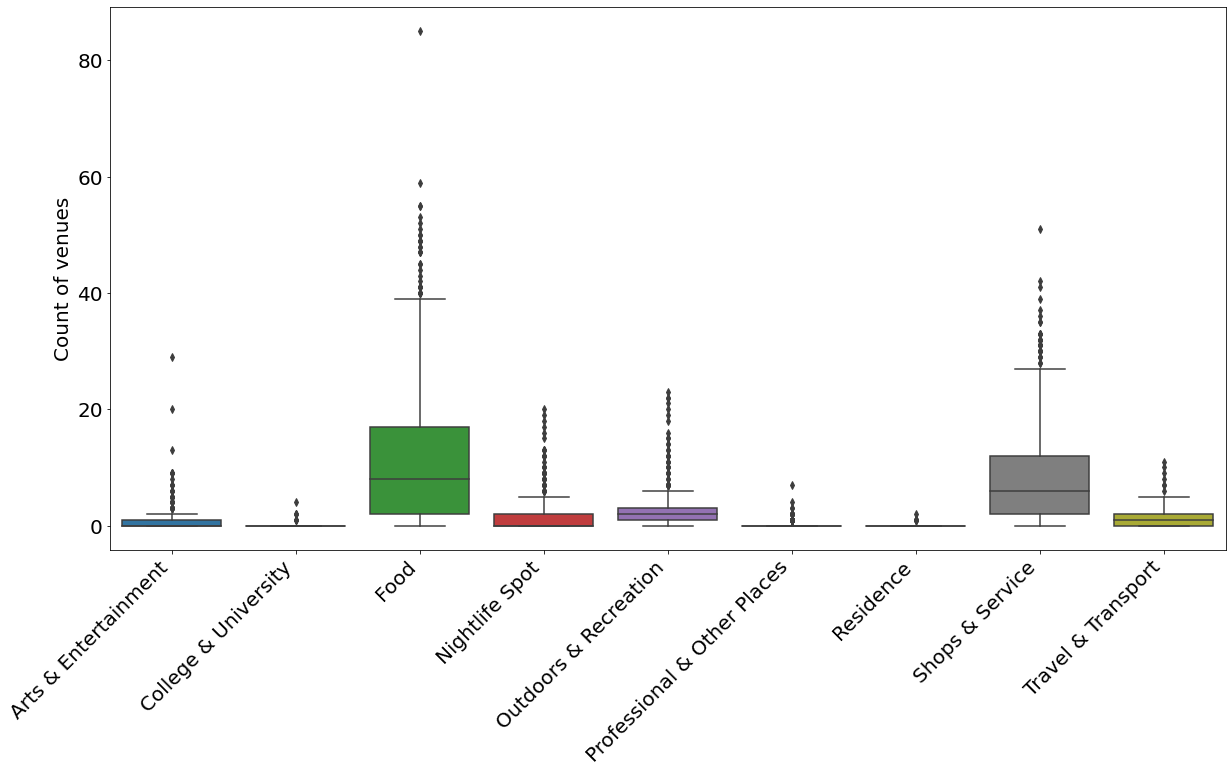

In [347]:
plt.figure(figsize=(20, 10))
plt.xticks(rotation='vertical')
sns.boxplot

ax = sns.boxplot(data = tmp[col_names])
#ax = sns.swarmplot(data=tmp_df, color="black", edgecolor="gray")
ax.set_ylabel('Count of venues', fontsize=20)
#ax.set_xlabel('Venue category', fontsize=20)
ax.tick_params(labelsize=20)
plt.xticks(rotation=45, ha='right')
plt.savefig('all_neighborhoods.png',dpi=600)
plt.show()

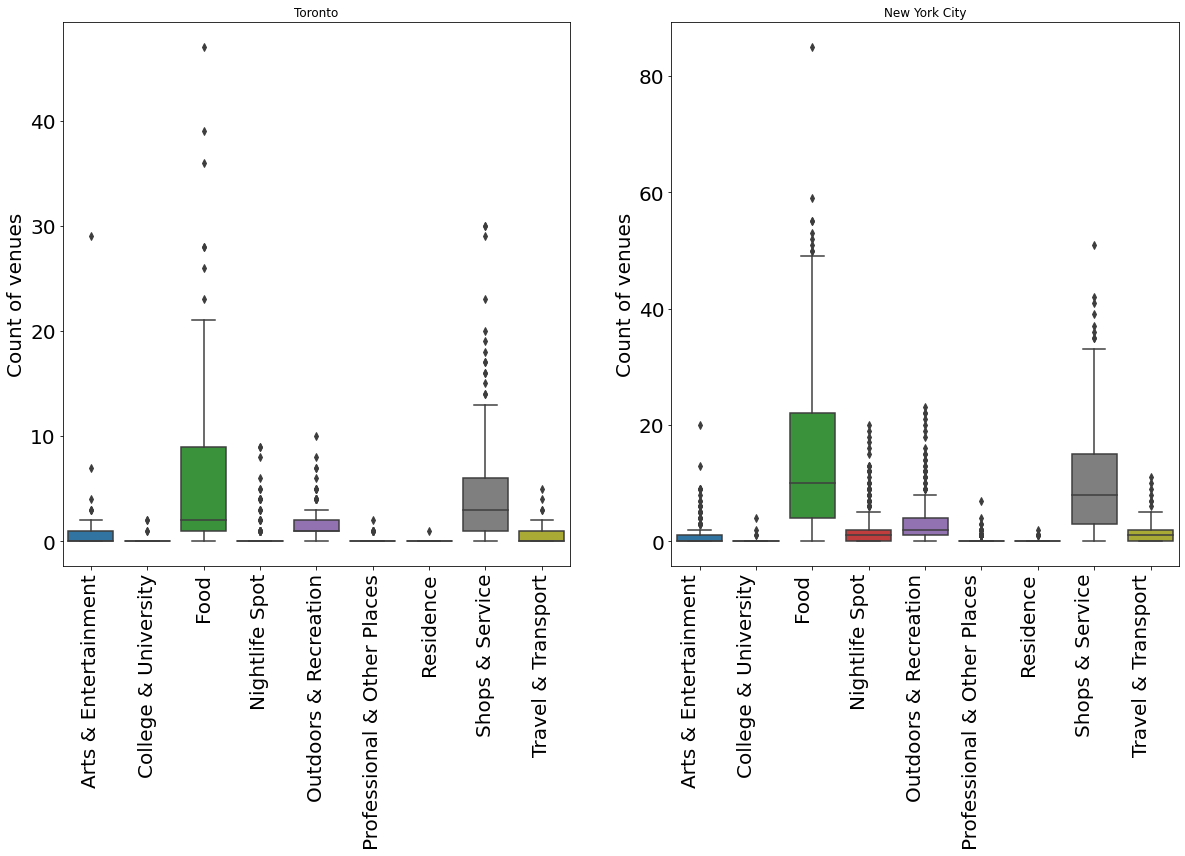

In [348]:
fig,axes = plt.subplots(1,2,figsize=(20, 10))
plt.xticks(rotation=45, ha='right')
bp0 = sns.boxplot(ax=axes[0], data = tmp[tmp.City=='Toronto'][col_names])
axes[0].set_ylabel('Count of venues', fontsize=20)
axes[0].tick_params(labelsize=20)
axes[0].set_title('Toronto')
bp0.set_xticklabels(bp0.get_xticklabels(),rotation=90)

bp1 = sns.boxplot(ax=axes[1], data = tmp[tmp.City!='Toronto'][col_names])
axes[1].set_ylabel('Count of venues', fontsize=20)
axes[1].tick_params(labelsize=20)
axes[1].set_title('New York City')
bp1.set_xticklabels(bp1.get_xticklabels(),rotation=90)

plt.savefig('comparison_venus_nyc_tor_raw.png',dpi=600)
# axes[1].xticks(rotation=45, ha='right')
plt.show()

As discussed in the previous sections, NYC is much larger with significant bigger population than is Toronto. It will yield some inaccuracy if we directly use the number of venus in each category for comparison purpose. A standardization process is necessary here for each city to make the data comparable. Here I use the MinMaxScaler to stretch the data. The formula is shown below.

<img src="https://i.stack.imgur.com/EuitP.png" width=400 style='margin-left: auto; margin-right: auto;'/>

In [19]:
from sklearn.preprocessing import MinMaxScaler

In [20]:
# columns whose data need be scaled
col_names = ['Arts & Entertainment', 'College & University', 'Food', 'Nightlife Spot', 'Outdoors & Recreation',
             'Professional & Other Places', 'Residence', 'Shops & Service', 'Travel & Transport']

In [21]:
# standardized the data for each city separately and merge the dataframes together

In [22]:
import warnings
warnings.filterwarnings('ignore')

In [23]:
data_std = []
for c in ['Toronto','New York City']:
    tdat = tmp[tmp.City==c]
    for col in col_names:
        tdat[[col]] = MinMaxScaler().fit_transform(tdat[[col]])
    data_std.append(tdat)
data  = pd.concat(data_std,axis=0)[['nid','City','neighborhood_name']+col_names]
data.head()

,nid,City,neighborhood_name,Arts & Entertainment,College & University,Food,Nightlife Spot,Outdoors & Recreation,Professional & Other Places,Residence,Shops & Service,Travel & Transport
302,303,Toronto,Agincourt North,0.000000,0.0,0.234043,0.000000,0.1,0.0,0.0,0.266667,0.0
303,304,Toronto,Agincourt South-Malvern West,0.034483,0.0,0.382979,0.000000,0.0,0.0,0.0,0.066667,0.2
304,305,Toronto,Alderwood,0.034483,0.0,0.042553,0.000000,0.1,0.0,0.0,0.100000,0.0
305,306,Toronto,Annex,0.000000,0.0,0.234043,0.222222,0.1,0.5,0.0,0.266667,0.0
306,307,Toronto,Banbury-Don Mills,0.034483,0.0,0.106383,0.000000,0.0,0.0,0.0,0.566667,0.2


#### Compare the standardized venus data for two cities

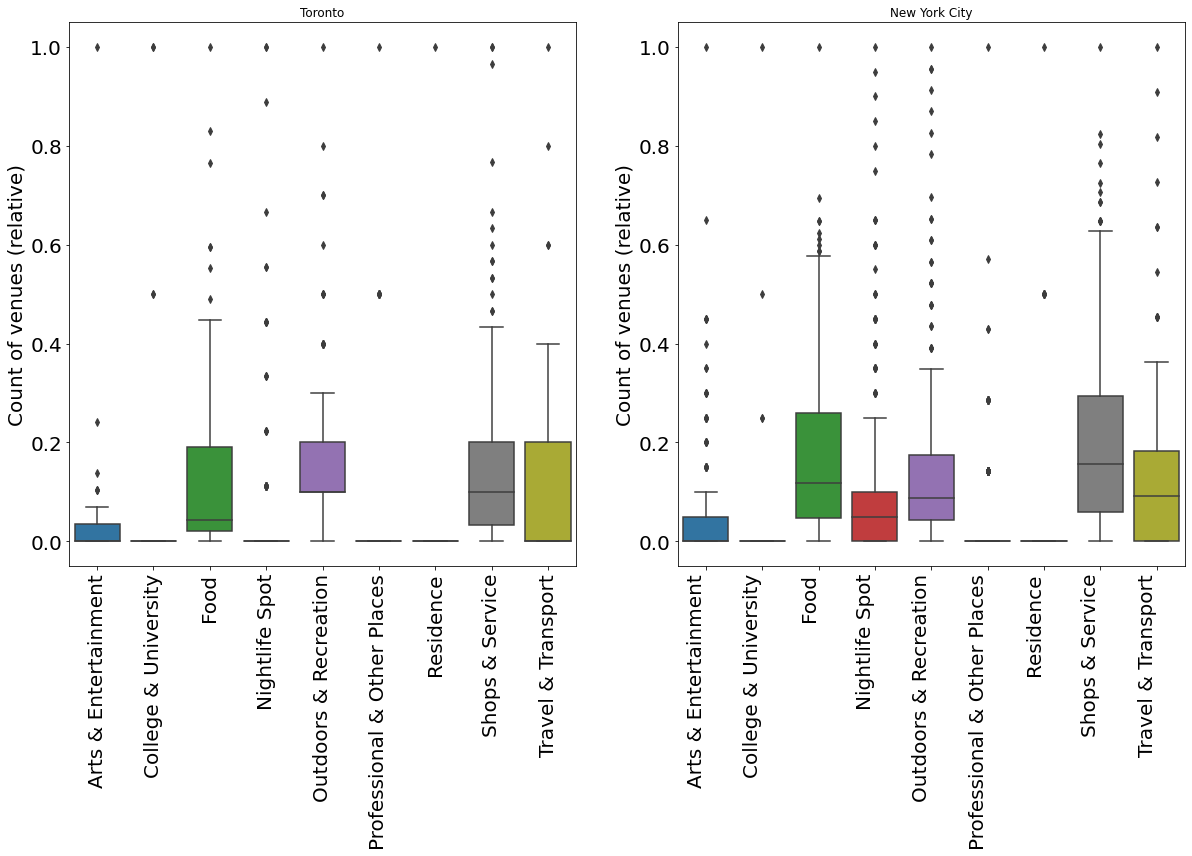

In [359]:
fig,axes = plt.subplots(1,2,figsize=(20, 10))
plt.xticks(rotation=45, ha='right')
bp0 = sns.boxplot(ax=axes[0], data = data[data.City=='Toronto'][col_names])
axes[0].set_ylabel('Count of venues (relative)', fontsize=20)
axes[0].tick_params(labelsize=20)
axes[0].set_title('Toronto')
bp0.set_xticklabels(bp0.get_xticklabels(),rotation=90)

bp1 = sns.boxplot(ax=axes[1], data = data[data.City!='Toronto'][col_names])
axes[1].set_ylabel('Count of venues (relative)', fontsize=20)
axes[1].tick_params(labelsize=20)
axes[1].set_title('New York City')
bp1.set_xticklabels(bp1.get_xticklabels(),rotation=90)

plt.savefig('comparison_venus_nyc_tor_relative.png',dpi=600)
# axes[1].xticks(rotation=45, ha='right')
plt.show()

#### 2.3.3 KMeans Clustering Analysis

In [24]:
from sklearn.cluster import KMeans
import numpy as np
from sklearn.metrics import silhouette_score


##### finding the optimal number of cluster

In [25]:
# ELBOW METHOD

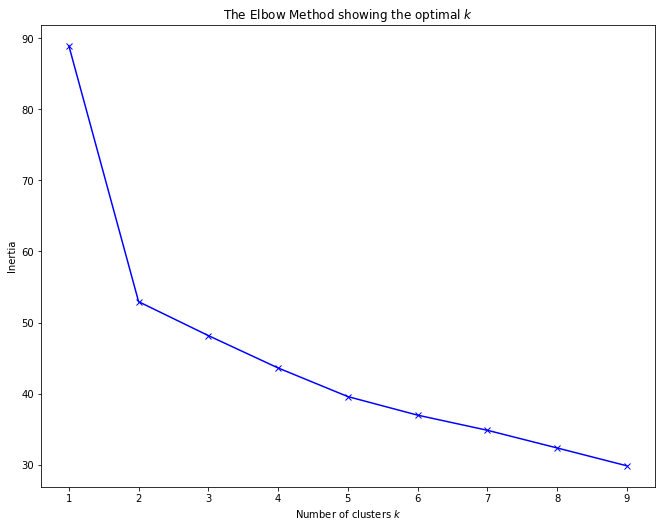

In [26]:
wss = []
for i in range(1,10):
    fitx = KMeans(n_clusters=i).fit(data[col_names])
    wss.append(fitx.inertia_)

plt.figure(figsize=(11,8.5))
plt.plot(range(1,10), wss, 'bx-')
plt.xlabel('Number of clusters $k$')
plt.ylabel('Inertia')
plt.title('The Elbow Method showing the optimal $k$')
plt.savefig('number_cluster_elbow.png',dpi=600)
plt.show()

The plot shows the best cluster number is 2.

In [27]:
#Silhouette Coefficient Method

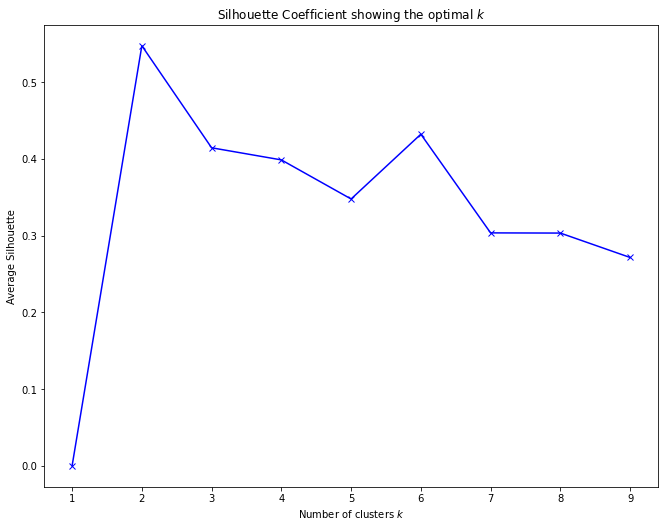

In [28]:
scores = [0]
for i in range(2,10):
    fitx = KMeans(n_clusters=i).fit(data[data.City=='Toronto'][col_names])
    score = silhouette_score(data[data.City=='Toronto'][col_names], fitx.labels_)
    scores.append(score)
    
plt.figure(figsize=(11,8.5))
plt.plot(range(1,10), np.array(scores), 'bx-')
plt.xlabel('Number of clusters $k$')
plt.ylabel('Average Silhouette')
plt.title('Silhouette Coefficient showing the optimal $k$')
plt.show()

The plot shows the best cluster number is 2 or 3.

##### KMeans Clustering with 5 Groups

Although the aboved two methods indicate the good cluster number for the analysis is 2 or 3, I continue my analysis with a cluster number of 5. The reason for me not using 2 or 3 is I want to show readers what are the answers for my initial questions. It is evident that NYC and Toronto are significantly different from each other which will automatically make 2 clusters. There is no educational purpose if I choose 2.

In [29]:
kclusters = 5

In [30]:
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(data[col_names])
print('The center of each feature:')
print(kmeans.cluster_centers_)
# add the cluster label to the dataframe
data['cluster'] = kmeans.labels_

The center of each feature:
[[0.02582459 0.01086957 0.07937912 0.02518116 0.11361059 0.00621118
  0.00543478 0.09317988 0.27865613]
 [0.20165517 0.03       0.40963204 0.22422222 0.62191304 0.3
  0.1        0.44321569 0.24945455]
 [0.03420531 0.00287356 0.22776171 0.08633461 0.13073463 0.05336617
  0.00574713 0.27793554 0.06687565]
 [0.12571533 0.03191489 0.52065614 0.5144208  0.2986124  0.03951368
  0.03191489 0.5718398  0.12030948]
 [0.01044571 0.00797872 0.05241792 0.01447991 0.08401943 0.01329787
  0.00531915 0.0764393  0.02079304]]


In [32]:
data['count'] = 1

In [37]:
# cluster and neighborhood for NYC and TORONTO

In [36]:
data.groupby(by=['cluster','City'])['count'].sum().unstack().T

cluster,0,1,2,3,4
City,,,,,
New York City,61,19,68,35,119
Toronto,31,6,19,12,69


#### 2.3.4 Cluster Visualize using Seaborn BoxPlot and Folium Leaflet Map

In [377]:
# Seaborn BoxPlot

In [372]:
import matplotlib.ticker as ticker

NameError: name 'sns' is not defined

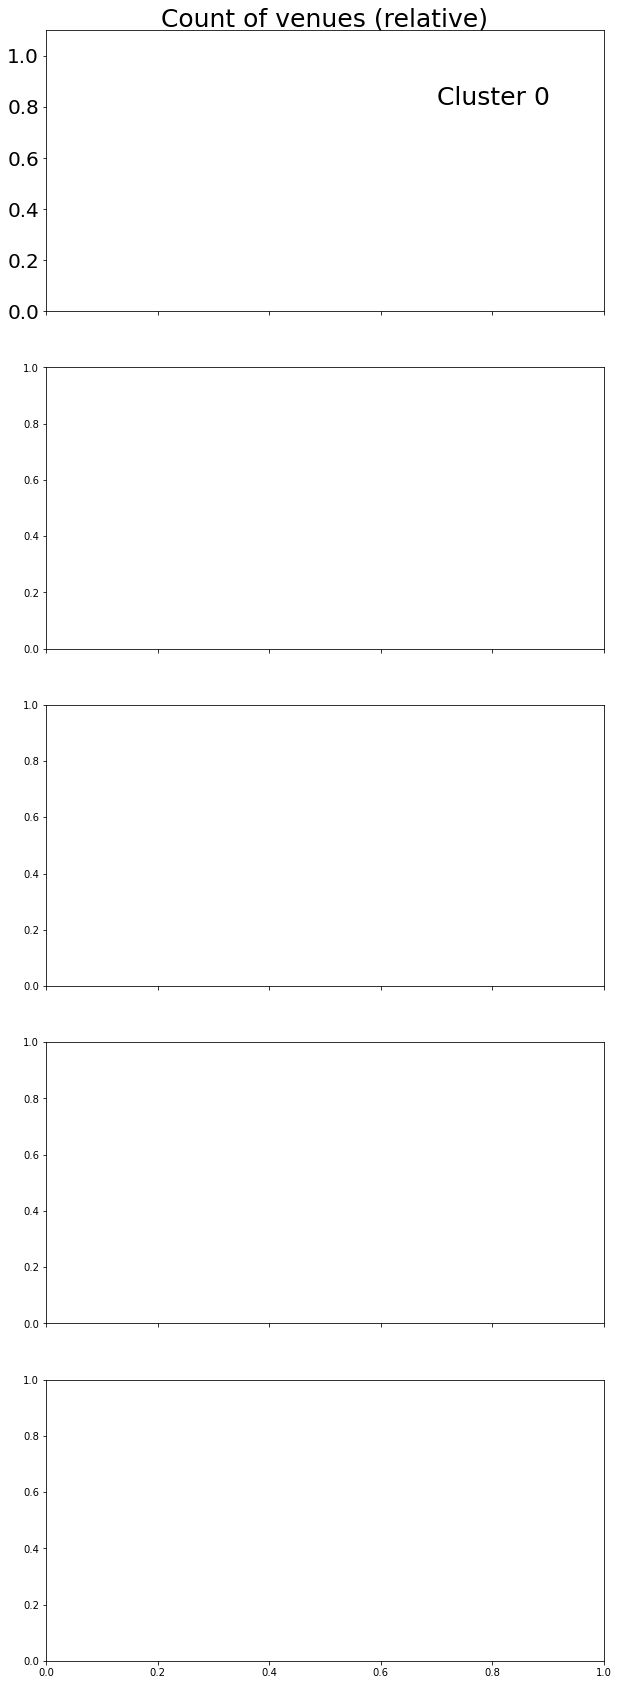

In [40]:
fig, axes = plt.subplots(5,1, figsize=(10, 30), sharex=True)
axes[0].set_xlabel('Count of venues (relative)', fontsize=25)

for k in range(kclusters):
    #Set same y axis limits
    axes[k].set_ylim(0,1.1)
    axes[k].xaxis.set_label_position('top')
    #axes[k].set_xlabel('Cluster ' + str(k), fontsize=25)
    axes[k].text(0.7, 0.8, 'Cluster ' + str(k), fontsize=25, ha="left", va="top", transform=axes[k].transAxes)
    axes[k].tick_params(labelsize=20)
    plt.sca(axes[k])
    plt.xticks(rotation='vertical')
    sns.boxplot(data = data[data.cluster==k][col_names], ax=axes[k],orient="h")
plt.tight_layout()
plt.savefig('comparison_clusters_nyc_tor.png')
plt.show()

In [378]:
#Folium Map

In [375]:
# add Latitude and Longitude columns
data['Latitude'] = data.neighborhood_name.apply(lambda x: dat0.loc[dat0.neighborhood_name==x,'Neighborhood Latitude'].values[0])
data['Longitude'] = data.neighborhood_name.apply(lambda x: dat0.loc[dat0.neighborhood_name==x,'Neighborhood Longitude'].values[0])
data.head()

,nid,City,neighborhood_name,Arts & Entertainment,College & University,Food,Nightlife Spot,Outdoors & Recreation,Professional & Other Places,Residence,Shops & Service,Travel & Transport,cluster,Latitude,Longitude
302,303,Toronto,Agincourt North,0.000000,0.0,0.234043,0.000000,0.1,0.0,0.0,0.266667,0.0,2,43.805433,-79.266700
303,304,Toronto,Agincourt South-Malvern West,0.034483,0.0,0.382979,0.000000,0.0,0.0,0.0,0.066667,0.2,0,43.788650,-79.265599
304,305,Toronto,Alderwood,0.034483,0.0,0.042553,0.000000,0.1,0.0,0.0,0.100000,0.0,4,43.604930,-79.541599
305,306,Toronto,Annex,0.000000,0.0,0.234043,0.222222,0.1,0.5,0.0,0.266667,0.0,2,43.671578,-79.403988
306,307,Toronto,Banbury-Don Mills,0.034483,0.0,0.106383,0.000000,0.0,0.0,0.0,0.566667,0.2,2,43.737651,-79.349709


In [376]:
# create map
map_clusters = folium.Map(location=[43.604930, -79.541599], zoom_start=11)
kclusters = 5
# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(data['Latitude'], data['Longitude'], data['neighborhood_name'], data['cluster']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

<img src='nyc_tor_cluster_map.png' width=800 style='margin:auto auto;'/>

#### 2.3.5 Examine the most common n venus for each clusters

In [379]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:][col_names]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

In [380]:
num_top_venues = 3

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['neighborhood_name']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted['neighborhood_name'] = data['neighborhood_name']

for ind in np.arange(data.shape[0]):
    neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(data.iloc[ind, :], num_top_venues)
    data[columns] = neighborhoods_venues_sorted[columns]

neighborhoods_venues_sorted.head()

,neighborhood_name,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue
302,Agincourt North,Shops & Service,Food,Outdoors & Recreation
303,Agincourt South-Malvern West,Food,Travel & Transport,Shops & Service
304,Alderwood,Shops & Service,Outdoors & Recreation,Food
305,Annex,Professional & Other Places,Shops & Service,Food
306,Banbury-Don Mills,Shops & Service,Travel & Transport,Food


In [381]:
for c in range(5):
    cnt_df = data[data.cluster==c].groupby(by='City')['nid'].count()
    print('='*60)
    print('='*2+" "*13+ 'Cluster %s (NYC:%s TOR: %s)'%(c,cnt_df['New York City'],cnt_df['Toronto'])+" "*13 + '='*2)
    print('='*60)
    for k in ['1st Most Common Venue', '2nd Most Common Venue','3rd Most Common Venue'][:1]:
        print(data[data.cluster==c][[k]].value_counts().rename_axis('Venue Category').reset_index(name=k))
        print('-'*60)
    #break
print('='*60)

==             Cluster 0 (NYC:61 TOR: 31)             ==
          Venue Category  1st Most Common Venue
0     Travel & Transport                     76
1  Outdoors & Recreation                      9
2        Shops & Service                      3
3              Residence                      1
4                   Food                      1
5   College & University                      1
6   Arts & Entertainment                      1
------------------------------------------------------------
==             Cluster 1 (NYC:19 TOR: 6)             ==
                Venue Category  1st Most Common Venue
0        Outdoors & Recreation                     12
1              Shops & Service                      4
2  Professional & Other Places                      3
3           Travel & Transport                      2
4                         Food                      2
5                    Residence                      1
6         Arts & Entertainment                      1
----------

#### Thank you!